<a href="https://colab.research.google.com/github/SKD151105/Skin-Cancer-Classification/blob/main/model-inference_V1/version2.0/normalize-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = '/content/drive/MyDrive/mini_proj_data/HAM10000'


In [8]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [9]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
787,HAM_0002042,ISIC_0028294,bkl,confocal,75.0,female,face,/content/drive/MyDrive/mini_proj_data/HAM10000...,Benign keratosis-like lesions,2
5319,HAM_0000253,ISIC_0030012,nv,follow_up,45.0,male,back,/content/drive/MyDrive/mini_proj_data/HAM10000...,Melanocytic nevi,4
5181,HAM_0000883,ISIC_0030631,nv,follow_up,50.0,male,abdomen,/content/drive/MyDrive/mini_proj_data/HAM10000...,Melanocytic nevi,4


In [10]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0000835,ISIC_0032258,nv,histo,male,back,/content/drive/MyDrive/mini_proj_data/HAM10000...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


<Axes: xlabel='cell_type'>

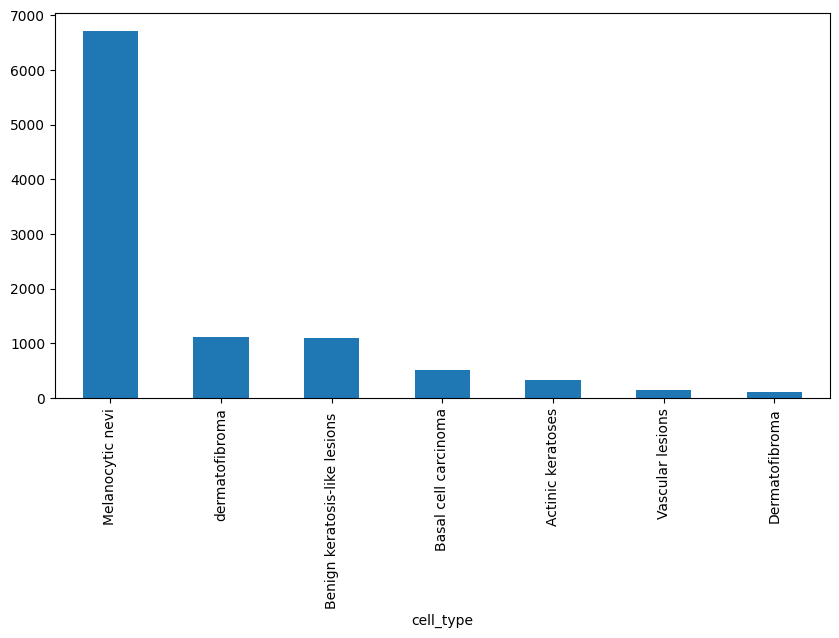

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
# load in all of the images
from skimage.io import imread
tile_df['image'] = tile_df['path'].map(imread)

In [ ]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

# Show off a few in each category


In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

## Get Average Color Information
Here we get and normalize all of the color channel information

In [ ]:
rgb_info_df = tile_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in
                                  zip(['Red', 'Green', 'Blue'],
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(3)

In [ ]:
for c_col in rgb_info_df.columns:
    tile_df[c_col] = rgb_info_df[c_col].values # we cant afford a copy

In [ ]:
sns.pairplot(tile_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']],
             hue='cell_type', plot_kws = {'alpha': 0.5})

# Show Color Range
Show how the mean color channel values affect images

In [ ]:
n_samples = 5
for sample_col in ['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean']:
    fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
    def take_n_space(in_rows, val_col, n):
        s_rows = in_rows.sort_values([val_col])
        s_idx = np.linspace(0, s_rows.shape[0]-1, n, dtype=int)
        return s_rows.iloc[s_idx]
    for n_axs, (type_name, type_rows) in zip(m_axs,
                                             tile_df.sort_values(['cell_type']).groupby('cell_type')):

        for c_ax, (_, c_row) in zip(n_axs,
                                    take_n_space(type_rows,
                                                 sample_col,
                                                 n_samples).iterrows()):
            c_ax.imshow(c_row['image'])
            c_ax.axis('off')
            c_ax.set_title('{:2.2f}'.format(c_row[sample_col]))
        n_axs[0].set_title(type_name)
    fig.savefig('{}_samples.png'.format(sample_col), dpi=300)

# Make a nice cover image
Make a cover image for the dataset using all of the tiles

In [ ]:
from skimage.util import montage
rgb_stack = np.stack(tile_df.\
                     sort_values(['cell_type', 'Red_mean'])['image'].\
                     map(lambda x: x[::5, ::5]).values, 0)
rgb_montage = np.stack([montage(rgb_stack[:, :, :, i]) for i in range(rgb_stack.shape[3])], -1)
print(rgb_montage.shape)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20), dpi=300)
ax1.imshow(rgb_montage)
fig.savefig('nice_montage.png')

In [ ]:
from skimage.io import imsave
# this is a big file, imsave('full_dataset_montage.png', rgb_montage)

# Make an MNIST Like Dataset
We can make an MNIST-like dataset by flattening the images into vectors and exporting them

In [ ]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

In [ ]:
from PIL import Image
def package_mnist_df(in_rows,
                     image_col_name = 'image',
                     label_col_name = 'cell_type_idx',
                     image_shape=(28, 28),
                     image_mode='RGB',
                     label_first=False
                    ):
    out_vec_list = in_rows[image_col_name].map(lambda x:
                                               np.array(Image.\
                                                        fromarray(x).\
                                                        resize(image_shape, resample=Image.LANCZOS).\
                                                        convert(image_mode)).ravel())
    out_vec = np.stack(out_vec_list, 0)
    out_df = pd.DataFrame(out_vec)
    n_col_names =  ['pixel{:04d}'.format(i) for i in range(out_vec.shape[1])]
    out_df.columns = n_col_names
    out_df['label'] = in_rows[label_col_name].values.copy()
    if label_first:
        return out_df[['label']+n_col_names]
    else:
        return out_df

In [ ]:
# from itertools import product
# for img_side_dim, img_mode in product([8, 28, 64, 128], ['L', 'RGB']):
#     if (img_side_dim==128) and (img_mode=='RGB'):
#         # 128x128xRGB is a biggie
#         break
#     out_df = package_mnist_df(tile_df,
#                               image_shape=(img_side_dim, img_side_dim),
#                              image_mode=img_mode)
#     out_path = f'hmnist_{img_side_dim}_{img_side_dim}_{img_mode}.csv'
#     out_df.to_csv(out_path, index=False)
#     print(f'Saved {out_df.shape} -> {out_path}: {os.stat(out_path).st_size/1024:2.1f}kb')

In [ ]:
from itertools import product
import os

# Your existing dataset directory
base_skin_dir = '/content/drive/MyDrive/mini_proj_data/HAM10000'

# Generate resized datasets at multiple resolutions (RGB only)
for img_side_dim in [200, 150, 128, 80, 64, 50]:
    img_mode = 'RGB'
    out_df = package_mnist_df(
        tile_df,
        image_shape=(img_side_dim, img_side_dim),
        image_mode=img_mode
    )

    # Save CSV inside the HAM10000 directory
    out_path = os.path.join(base_skin_dir, f'hmnist_{img_side_dim}_{img_side_dim}_{img_mode}.csv')
    out_df.to_csv(out_path, index=False)

    print(f"✅ Saved {out_df.shape} -> {out_path}: {os.stat(out_path).st_size/1024:2.1f} KB")
